<a href="https://colab.research.google.com/github/matthiaspfenninger/fsdl-active-learning/blob/tf_deep_weeds/Active_learning_AgriAI_ResNet50_TL_max_entropy_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Detection of weeds using Deep Learning 

>Weeds compete with productive
crops or pasture, they can be
poisonous, distasteful, produce burrs,
thorns or otherwise interfere with
the use and management of desirable
plants by contaminating harvests or
interfering with livestock.
Weeds also compete with crops for
space, nutrients, water and light
thereby disallowing edible crops to
grow healthily.

> According to Wikipedia, smaller,
slower growing seedlings are more
susceptible than those that are
larger and more vigorous. Onions are
one of the most vulnerable, because
they are slow to germinate and
produce slender, upright stems.

> Robotic weed control has seen increased research of late with its potential for boosting productivity in
agriculture. Majority of works focus on developing robotics for croplands, ignoring the weed
management problems facing rangeland stock farmers. Perhaps the greatest obstacle to widespread
uptake of robotic weed control is the robust classification of weed species in their natural environment.

> [The DeepWeeds dataset](https://github.com/AlexOlsen/DeepWeeds) consists of 17,509 labelled images of eight nationally significant weed
species native to eight locations across northern Australia.
In order to solve this Agriculture AI problem, we’re going to train a classifier that’s going to take in
images and predict the category it belongs to. 

Import necessary Modules 

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,Concatenate,Lambda,Activation,Input,Dropout
 
from tensorflow.keras.optimizers import Adam,SGD
 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.data import Dataset

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

import math



In [2]:
!pip install wandb -qqq
import wandb
wandb.login()


     |████████████████████████████████| 2.1MB 5.7MB/s 
     |████████████████████████████████| 102kB 9.0MB/s 
     |████████████████████████████████| 163kB 40.8MB/s 
     |████████████████████████████████| 133kB 42.3MB/s 
     |████████████████████████████████| 71kB 7.6MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
run=wandb.init(name='Max_entropy_1', 
           project='Active_Learning_Deep_Weeds',
           notes='First Run Active Learning for Deep Weeds Dataset using Max entropy Sampling', 
           tags=['Deep Weeds', 'Active Learning', 'Max Entropy Sampling'])

wandb: Currently logged in as: ravindra (use `wandb login --relogin` to force relogin)


### Install tf_utils package for deep_weeds 

In [4]:
!pip install --upgrade git+https://github.com/ravindrabharathi/tf_utils@active_learning

  Cloning https://github.com/ravindrabharathi/tf_utils (to revision active_learning) to /tmp/pip-req-build-8s6z4f70
  Running command git clone -q https://github.com/ravindrabharathi/tf_utils /tmp/pip-req-build-8s6z4f70
  Running command git checkout -b active_learning --track origin/active_learning
  Switched to a new branch 'active_learning'
  Branch 'active_learning' set up to track remote branch 'active_learning' from 'origin'.
  Created wheel for tf-utils: filename=tf_utils-0.3-cp37-none-any.whl size=10440 sha256=24cd98e609fd5178732a34afcc0c536b5946b5451dcb4d8dc4e4dda200e64822
  Stored in directory: /tmp/pip-ephem-wheel-cache-yxfu0ug0/wheels/06/be/37/6de2e393f5479f43268c69f904f991765bc7f12c38f35b9afe
Successfully built tf-utils


### Import data, transforms and Visualization modules from tf_utils

In [5]:
import tf_utils.data as ds 
import tf_utils.visualize as vz
import tf_utils.transform as tfm

### Mount Google Drive for to copy Images and labels 

In [6]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


### copy images zip and labels csv from google drive 

In [7]:
!cp '/gdrive/My Drive/LiveAI/AgriAI/images.zip' '.'

In [8]:
!cp '/gdrive/My Drive/LiveAI/AgriAI/labels_deep_weeds.csv' '.'

### Unzip images to 'data' directory 

In [9]:
!mkdir data

In [10]:
!unzip -uq "images.zip" -d ./data

### Check number of images are correct in the data directory 

In [11]:
import os
file_list=os.listdir('./data')
len(file_list)

17509

### Read the labels into a dataframe 

In [12]:
data=pd.read_csv('labels_deep_weeds.csv')
data.head()

Filename  Label       Species
0  20160928-140314-0.jpg      0  Chinee apple
1  20160928-140337-0.jpg      0  Chinee apple
2  20160928-140731-0.jpg      0  Chinee apple
3  20160928-140747-0.jpg      0  Chinee apple
4  20160928-141107-0.jpg      0  Chinee apple

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17509 entries, 0 to 17508
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filename  17509 non-null  object
 1   Label     17509 non-null  int64 
 2   Species   17509 non-null  object
dtypes: int64(1), object(2)
memory usage: 410.5+ KB


### Create train, validation and test DataFrames 

In [14]:
train_df1,train_df,test_df=ds.split_train_test_df(data)


In [15]:
train_df1.head()

Filename  Label       Species
0  20171218-114855-3.jpg      8      Negative
1  20160928-141421-0.jpg      0  Chinee apple
2  20171217-184330-2.jpg      8      Negative
3  20170714-150115-1.jpg      1       Lantana
4  20171219-100828-2.jpg      8      Negative

### Check that the dataframe shapes are as expected 60% train,20% validation and 20% Test split

In [16]:
train_df1.shape,train_df.shape,test_df.shape

((3501, 3), (10506, 3), (3502, 3))

### Print information about the data
-- How many Classes are Present 

-- What is the Count for each class

-- Plot a histogram of the class counts 



Class Mapping
-----------------
   Label         Species
0      0    Chinee apple
1      1         Lantana
2      2     Parkinsonia
3      3      Parthenium
4      4  Prickly acacia
5      5     Rubber vine
6      6       Siam weed
7      7      Snake weed
8      8        Negative
---------------------

Count per Species
-----------------
          Species  Total
0        Negative   9106
1    Chinee apple   1125
2       Siam weed   1074
3         Lantana   1064
4  Prickly acacia   1062
5     Parkinsonia   1031
6      Parthenium   1022
7      Snake weed   1016
8     Rubber vine   1009
---------------------



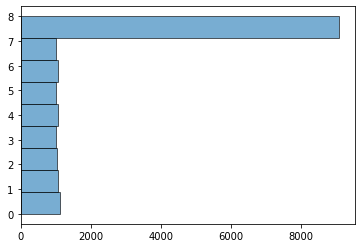

In [17]:
vz.visualize_data(data)

### Plot some sample images from each Class

In [18]:
vz.show_image_sample(data_df=data,images_dir='./data')

### Print Class Name - Label Mapping 

In [19]:
class_map,species_names=ds.get_class_map_and_species_names(data)

In [20]:
print(class_map,'\n\n',species_names)

   Label         Species
0      0    Chinee apple
1      1         Lantana
2      2     Parkinsonia
3      3      Parthenium
4      4  Prickly acacia
5      5     Rubber vine
6      6       Siam weed
7      7      Snake weed
8      8        Negative 

 {0: 'Chinee apple', 1: 'Lantana', 2: 'Parkinsonia', 3: 'Parthenium', 4: 'Prickly acacia', 5: 'Rubber vine', 6: 'Siam weed', 7: 'Snake weed', 8: 'Negative'}


### Create tf records

In [21]:
ds.create_tf_records()


Generating ./tf_train/train.tfrecords
Finished 'convert_to_tfrecord' in 7.3556 secs
Done!
Generating ./tf_train/unlabelled.tfrecords
Finished 'convert_to_tfrecord' in 30.9430 secs
Done!
Generating ./tf_train/test.tfrecords
Finished 'convert_to_tfrecord' in 20.8796 secs
Done!
Finished 'create_tf_records' in 59.1957 secs


### Create the train, validation and Test Datasets
Train dataset has distortions set to True and so the images will be augmented with Cutout and Random Horizontal Flip

In [22]:
train_ds=ds.get_train_ds(distort=True)
unlabelled_ds=ds.get_unlabelled_ds()
test_ds=ds.get_test_ds()

distorting...
Finished 'get_tf_dataset_2' in 6.1853 secs
returning dataset for  2.4.1
Finished 'get_tf_dataset_in_batches' in 6.1861 secs
Finished 'get_train_ds' in 6.1868 secs
---parse batch -----
<dtype: 'uint8'> (None, None) Tensor("strided_slice:0", shape=(), dtype=int32)
Finished 'get_tf_dataset' in 0.1445 secs
returning dataset for  2.4.1
Finished 'get_tf_dataset_in_batches' in 0.1453 secs
Finished 'get_unlabelled_ds' in 0.1457 secs
---parse batch -----
<dtype: 'uint8'> (None, None) Tensor("strided_slice:0", shape=(), dtype=int32)
Finished 'get_tf_dataset' in 0.0399 secs
returning dataset for  2.4.1
Finished 'get_tf_dataset_in_batches' in 0.0407 secs
Finished 'get_test_ds' in 0.0411 secs


### Plot some images /label pairs from Train, Validation and Test Dataset 

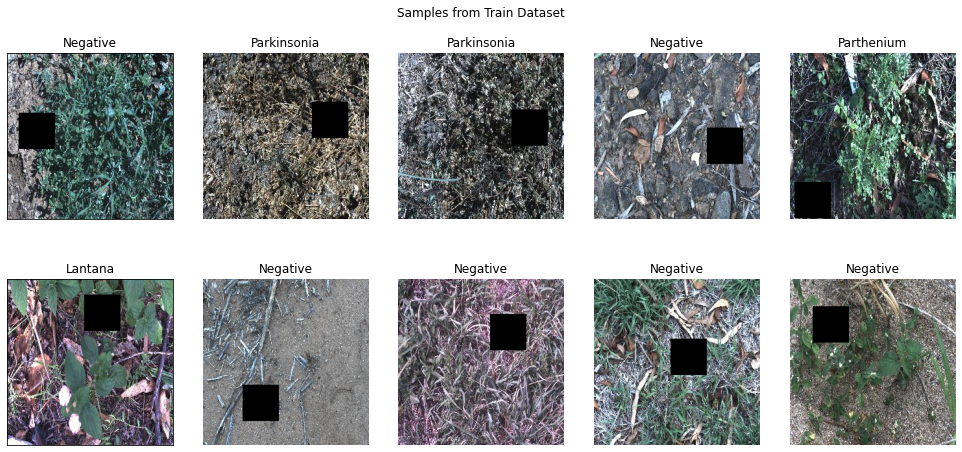

In [23]:
vz.plot_images_from_ds(train_ds,"Samples from Train Dataset",species_names)

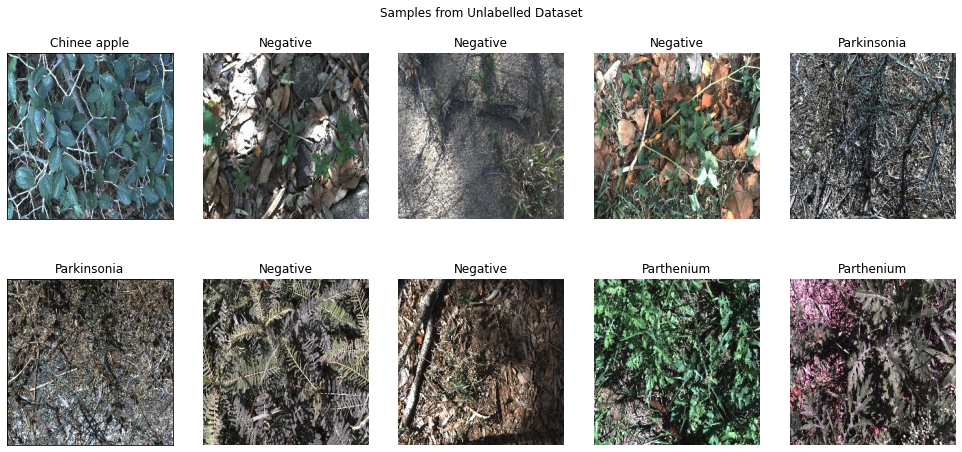

In [24]:
vz.plot_images_from_ds(unlabelled_ds,"Samples from Unlabelled Dataset",species_names)

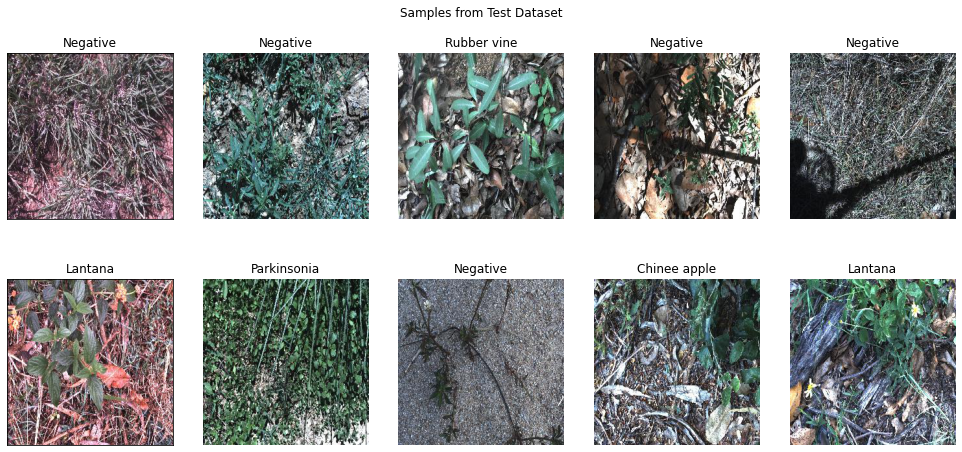

In [25]:
vz.plot_images_from_ds(test_ds,"Samples from Test Dataset",species_names)

###Model Creation

1. We will use ResNet50 trained on ImageNet as the base model.

2. We will Add two Linear Dense layers of size 1024 and 512 to the Head of the base Model with Relu activation 

3. Finally Add a Dense Layer with Softmax activation for Prediction 

4. The Image size for this dataset is 256 x256 . 


### Import Required TF modules for model creation 

In [26]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D ,Input,Conv2D,MaxPool2D,Lambda
import tensorflow as tf

### Define and compile model 
Compile model with SGD optimizer using a learning rate of 0.01 and Categorical Cross Entropy as loss function  ( the labels are one-hot encoded while creating Dataset .If not we could use 'Sparse Categorical Cross Entropy') . 

We may also need to revisit the loss function and the model prediction layer to see if we can deal in a better manner with the imbalance caused by the disproportionately large number of Negative samples 

For initial training run , the base model layers are frozen 

In [27]:
img_size=256
  
input_layer=Input(shape=(img_size,img_size,3))
inp1=Lambda(lambda x:tfm.random_crop(x))(input_layer) # crop image to 224 x224 
base_model=ResNet50(weights='imagenet',include_top=False,input_tensor=inp1)

x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add two fully-connected layers
x = Dense(1024, activation='relu')(x)
x = Dropout(0.15)(x)
x = Dense(512, activation='relu')(x)
# and a softmax layer
predictions = Dense(ds.num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Resnet50 layers
for layer in base_model.layers:
    layer.trainable = False

opt=SGD(lr=0.01,momentum=0.9,nesterov=True)
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])


94773248/94765736 [==============================] - 1s 0us/step


### Print Model summary 

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           lambda[0][0]                     
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
______________________________________________________________________________________________

### Model Checkpoint Callback for saving model with best accuracy 
Define a modelCheckpoint monitoring validation accuracy so that we can save the model with best validation accuracy 

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint
 
model_cpt=ModelCheckpoint(filepath='/gdrive/My Drive/LiveAI/active_learning/best_agri_model_entropy_sample.h5', 
                          verbose=1, save_best_only=True,monitor='val_accuracy',mode='auto')

In [30]:
class Log2wandb_Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    wandb.log({
        "Epoch": epoch,
        "Train Loss": logs["loss"],
        "Train Acc": logs["accuracy"],
        "Test Loss": logs["val_loss"],
        "Test Acc": logs["val_accuracy"],
        "Train size": len(train_df1),
        "Test Size": len(test_df)
        })
        

### train the model for 50 epochs with 25% train labels 

In [31]:
batch_size=ds.batch_size
EPOCHS=50
callback_list=[Log2wandb_Callback()]
model_history=model.fit(train_ds, epochs=EPOCHS, 
                        steps_per_epoch=np.ceil(len(train_df1)/batch_size), 
                        validation_data=test_ds,
                    validation_steps=np.ceil(len(test_df)/batch_size),
                    shuffle=True,callbacks=callback_list,verbose=1)


Epoch 1/50
28/28 [==============================] - 78s 2s/step - loss: 2.0460 - accuracy: 0.4378 - val_loss: 1.0727 - val_accuracy: 0.6289
Epoch 2/50
28/28 [==============================] - 41s 1s/step - loss: 1.0144 - accuracy: 0.6353 - val_loss: 0.8549 - val_accuracy: 0.6945
Epoch 3/50
28/28 [==============================] - 41s 1s/step - loss: 0.8455 - accuracy: 0.6905 - val_loss: 0.7763 - val_accuracy: 0.7282
Epoch 4/50
28/28 [==============================] - 41s 1s/step - loss: 0.7451 - accuracy: 0.7331 - val_loss: 0.7471 - val_accuracy: 0.7369
Epoch 5/50
28/28 [==============================] - 41s 1s/step - loss: 0.6996 - accuracy: 0.7567 - val_loss: 0.7103 - val_accuracy: 0.7575
Epoch 6/50
28/28 [==============================] - 41s 1s/step - loss: 0.6470 - accuracy: 0.7658 - val_loss: 0.6763 - val_accuracy: 0.7740
Epoch 7/50
28/28 [==============================] - 41s 1s/step - loss: 0.6255 - accuracy: 0.7682 - val_loss: 0.6269 - val_accuracy: 0.7840
Epoch 8/50
28/28 [==

### Plot training history 

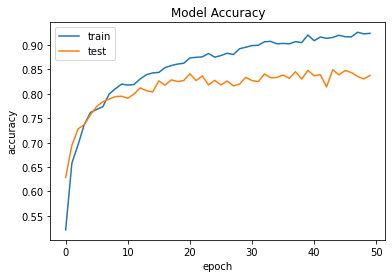

In [32]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

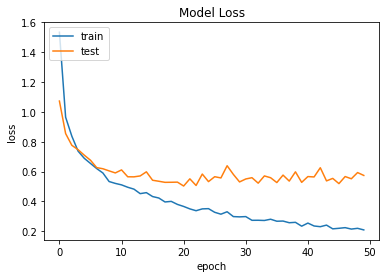

In [33]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### The accuracy as well as loss start diverging at about the 18th Epoch .  We could run a second iteration where we reduce the learning rate after the 20th, 40th and 60th epochs . Also we should follow up with fine tuning by unfreezing some of the base model layers and training with very low learning rate. We should also be training for a longer training run than just 80 epochs 

### Save a copy of the model in google Drive 

In [34]:
model.save('/gdrive/My Drive/LiveAI/active_learning/best_agri_model2_entropy_sample.h5')

### Evaluate Model with test data 

In [ ]:
results=model.evaluate(test_ds,steps=np.ceil(len(test_df)/batch_size))


### Print Evaluation Results 

In [36]:
print(results)

[0.5693745017051697, 0.841796875]


#### Model now has a 84% accuracy for the Test set 

### Plot confusion matrix for test dataset

In [ ]:
num_steps=np.ceil(len(test_df)/batch_size)
total_samples=len(test_df)
vz.plot_confusion_matrix(model,test_ds,num_steps,total_samples,list(species_names.values()))

### get 25% unlaballed data for labelling and Training

In [ ]:
num_steps=np.ceil(len(train_df)/batch_size)
total_samples=len(train_df)
sample_size=0.25
train_df1,train_df=ds.add_max_entropy_based_samples(model,unlabelled_ds,num_steps,total_samples,sample_size)


In [ ]:
#create train_ds and unlabelled_ds once again, test_ds is untouched 
ds.create_tf_records(overwrite=True)

In [40]:
train_ds=ds.get_train_ds(distort=True)
unlabelled_ds=ds.get_unlabelled_ds()

distorting...
Finished 'get_tf_dataset_2' in 0.1296 secs
returning dataset for  2.4.1
Finished 'get_tf_dataset_in_batches' in 0.1303 secs
Finished 'get_train_ds' in 0.1307 secs
---parse batch -----
<dtype: 'uint8'> (None, None) Tensor("strided_slice:0", shape=(), dtype=int32)
Finished 'get_tf_dataset' in 0.0358 secs
returning dataset for  2.4.1
Finished 'get_tf_dataset_in_batches' in 0.0365 secs
Finished 'get_unlabelled_ds' in 0.0368 secs


In [ ]:
vz.plot_images_from_ds(train_ds,"Samples from Train Dataset",species_names)

In [ ]:
batch_size=ds.batch_size
EPOCHS=90
#callback_list=[model_cpt]
model_history=model.fit(train_ds, epochs=EPOCHS, initial_epoch=50,
                        steps_per_epoch=np.ceil(len(train_df1)/batch_size), 
                        validation_data=test_ds,
                    validation_steps=np.ceil(len(test_df)/batch_size), 
                    shuffle=True,callbacks=callback_list,verbose=1)

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
results=model.evaluate(test_ds,steps=np.ceil(len(test_df)/batch_size))

28/28 [==============================] - 21s 725ms/step - loss: 0.4195 - accuracy: 0.8742


### Add another 35% data from unlabelled set 

In [ ]:
num_steps=np.ceil(len(train_df)/batch_size)
total_samples=len(train_df)
sample_size=0.35
train_df1,train_df=ds.add_max_entropy_based_samples(model,unlabelled_ds,num_steps,total_samples,sample_size)

In [ ]:
#create train_ds and unlabelled_ds once again, test_ds is untouched 
ds.create_tf_records(overwrite=True)

In [ ]:
train_ds=ds.get_train_ds(distort=True)
unlabelled_ds=ds.get_unlabelled_ds()

In [ ]:
batch_size=ds.batch_size
EPOCHS=130
#callback_list=[model_cpt]
model_history=model.fit(train_ds, epochs=EPOCHS, initial_epoch=90,
                        steps_per_epoch=np.ceil(len(train_df1)/batch_size), 
                        validation_data=test_ds,
                    validation_steps=np.ceil(len(test_df)/batch_size), 
                    shuffle=True,callbacks=callback_list,verbose=1)

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [52]:
results=model.evaluate(test_ds,steps=np.ceil(len(test_df)/batch_size))

28/28 [==============================] - 21s 723ms/step - loss: 0.3705 - accuracy: 0.8954


### Add 50% of remaining unlabelled set 

In [ ]:
num_steps=np.ceil(len(train_df)/batch_size)
total_samples=len(train_df)
sample_size=0.50
train_df1,train_df=ds.add_max_entropy_based_samples(model,unlabelled_ds,num_steps,total_samples,sample_size)


In [ ]:
#create train_ds and unlabelled_ds once again, test_ds is untouched 
ds.create_tf_records(overwrite=True)

In [ ]:
train_ds=ds.get_train_ds(distort=True)
unlabelled_ds=ds.get_unlabelled_ds()

In [ ]:
batch_size=ds.batch_size
EPOCHS=170
#callback_list=[model_cpt]
model_history=model.fit(train_ds, epochs=EPOCHS,initial_epoch=130,
                        steps_per_epoch=np.ceil(len(train_df1)/batch_size),  
                        validation_data=test_ds,
                    validation_steps=np.ceil(len(test_df)/batch_size),
                    shuffle=True,callbacks=callback_list,verbose=1)

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### Add remaining unlabelled data 

In [ ]:
num_steps=np.ceil(len(train_df)/batch_size)
total_samples=len(train_df)
sample_size=0.99
train_df1,train_df=ds.add_max_entropy_based_samples(model,unlabelled_ds,num_steps,total_samples,sample_size)


In [60]:
#create train_ds and unlabelled_ds once again, test_ds is untouched 
ds.create_tf_records(overwrite=True)

Generating ./tf_train/train.tfrecords
Finished 'convert_to_tfrecord' in 38.1774 secs
Done!
Generating ./tf_train/unlabelled.tfrecords
Finished 'convert_to_tfrecord' in 0.0539 secs
Done!
Generating ./tf_train/test.tfrecords
Finished 'convert_to_tfrecord' in 17.6231 secs
Done!
Finished 'create_tf_records' in 56.2299 secs


In [ ]:
train_ds=ds.get_train_ds(distort=True)
unlabelled_ds=ds.get_unlabelled_ds()

In [ ]:
batch_size=ds.batch_size
EPOCHS=210
#callback_list=[model_cpt]
model_history=model.fit(train_ds, epochs=EPOCHS,initial_epoch=170,
                        steps_per_epoch=np.ceil(len(train_df1)/batch_size),  
                        validation_data=test_ds,
                    validation_steps=np.ceil(len(test_df)/batch_size),
                    shuffle=True,callbacks=callback_list,verbose=1)

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
results=model.evaluate(test_ds,steps=np.ceil(len(test_df)/batch_size))

In [ ]:
num_steps=np.ceil(len(test_df)/batch_size)
total_samples=len(test_df)
vz.plot_confusion_matrix(model,test_ds,num_steps,total_samples,list(species_names.values()))

In [ ]:
run.finish()